In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# 1. Prepare Data Augmentation (Crucial for small datasets)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Load your dataset from your local path
# Path: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset
train_dir = r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset' 
dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 3. Load Pre-trained VGG16
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# 4. Freeze all convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# 5. Modify the Classifier for 6 classes
# We add a bit more dropout (0.5) to handle the small data size
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 6) # 6 classes for your paddy dataset
)

# 6. Loss and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

In [2]:
import torch

epochs = 20  # Start with 20 epochs for a small dataset
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_acc = 100. * correct / total
    print(f'Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Acc: {epoch_acc:.2f}%')

Epoch 1/20 | Loss: 1.5881 | Acc: 33.96%
Epoch 2/20 | Loss: 1.2398 | Acc: 52.52%
Epoch 3/20 | Loss: 0.9459 | Acc: 63.05%
Epoch 4/20 | Loss: 0.7814 | Acc: 73.74%
Epoch 5/20 | Loss: 0.6666 | Acc: 74.37%
Epoch 6/20 | Loss: 0.6006 | Acc: 77.52%
Epoch 7/20 | Loss: 0.5462 | Acc: 80.82%
Epoch 8/20 | Loss: 0.4557 | Acc: 82.70%
Epoch 9/20 | Loss: 0.4781 | Acc: 83.02%
Epoch 10/20 | Loss: 0.4256 | Acc: 84.43%
Epoch 11/20 | Loss: 0.3383 | Acc: 88.36%
Epoch 12/20 | Loss: 0.3359 | Acc: 89.15%
Epoch 13/20 | Loss: 0.3264 | Acc: 87.58%
Epoch 14/20 | Loss: 0.2797 | Acc: 89.78%
Epoch 15/20 | Loss: 0.2392 | Acc: 91.67%
Epoch 16/20 | Loss: 0.3235 | Acc: 88.36%
Epoch 17/20 | Loss: 0.2459 | Acc: 91.35%
Epoch 18/20 | Loss: 0.1989 | Acc: 91.67%
Epoch 19/20 | Loss: 0.2573 | Acc: 90.41%
Epoch 20/20 | Loss: 0.2039 | Acc: 92.61%


In [3]:
torch.save(model.state_dict(), 'paddy_vgg16_model.pth')

Generating predictions...


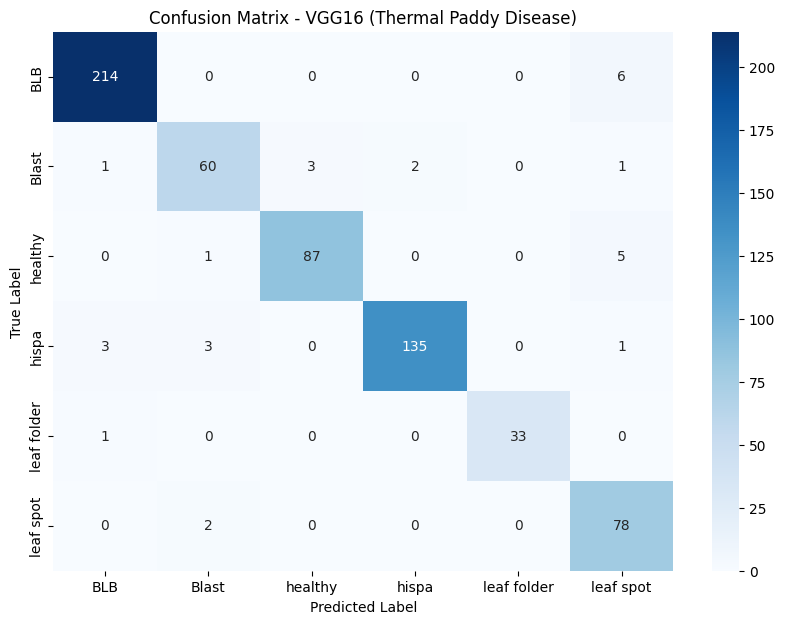

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Switch to Evaluation Mode
model.eval()
y_true = []
y_pred = []

# 2. Iterate through the dataset (Use your Test/Validation Loader here if you have one!)
# If you don't have a separate test loader yet, you can use 'train_loader' just to see 
# the matrix, but for the paper, this MUST be done on unseen data.
print("Generating predictions...")
with torch.no_grad():
    for inputs, labels in train_loader: # <--- CHANGE this to 'test_loader' for final paper results
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 3. Create the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = dataset.classes # This gets your folder names automatically

# 4. Plotting using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - VGG16 (Thermal Paddy Disease)')
plt.show()

In [7]:
from sklearn.metrics import classification_report

# Use the y_true and y_pred lists you created for the confusion matrix
report = classification_report(y_true, y_pred, target_names=dataset.classes)
print(report)

              precision    recall  f1-score   support

         BLB       0.98      0.97      0.97       220
       Blast       0.91      0.90      0.90        67
     healthy       0.97      0.94      0.95        93
       hispa       0.99      0.95      0.97       142
 leaf folder       1.00      0.97      0.99        34
   leaf spot       0.86      0.97      0.91        80

    accuracy                           0.95       636
   macro avg       0.95      0.95      0.95       636
weighted avg       0.96      0.95      0.95       636



Classes found: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']
Starting training on cuda for 5 epochs...
Epoch 1/5 | Loss: 1.5301 | Acc: 37.40%
Epoch 2/5 | Loss: 0.9807 | Acc: 64.76%
Epoch 3/5 | Loss: 0.5847 | Acc: 78.74%
Epoch 4/5 | Loss: 0.3005 | Acc: 90.75%
Epoch 5/5 | Loss: 0.1936 | Acc: 91.73%

Generating evaluation metrics...


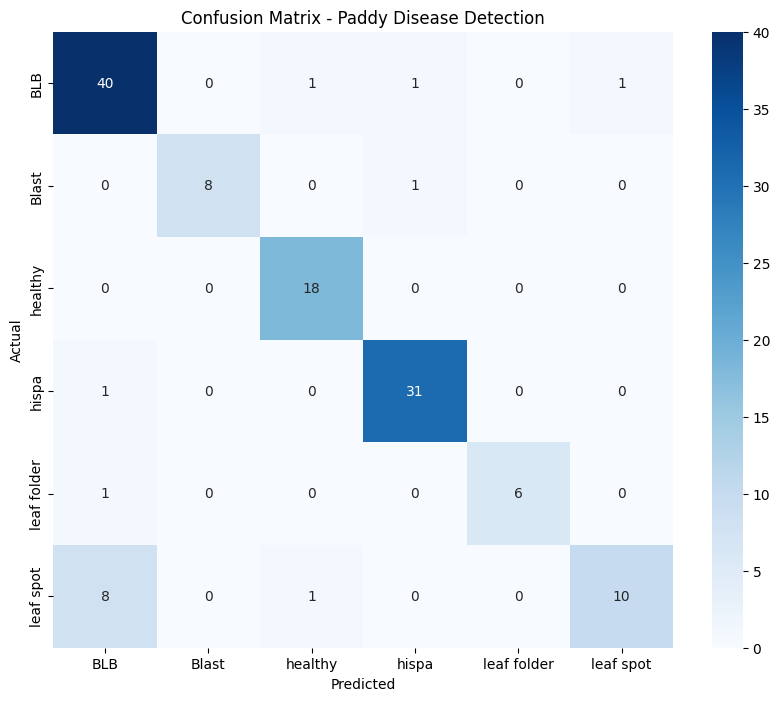


Classification Report:

              precision    recall  f1-score   support

         BLB       0.80      0.93      0.86        43
       Blast       1.00      0.89      0.94         9
     healthy       0.90      1.00      0.95        18
       hispa       0.94      0.97      0.95        32
 leaf folder       1.00      0.86      0.92         7
   leaf spot       0.91      0.53      0.67        19

    accuracy                           0.88       128
   macro avg       0.92      0.86      0.88       128
weighted avg       0.89      0.88      0.88       128


=== TREATMENT PRESCRIPTIONS ===
[BLB]: Spray Streptocycline (1g) + Copper Oxychloride (30g) per 10L water. Drain field if possible.
[Blast]: Apply Tricyclazole 75 WP (0.6g/L) or Carbendazim 50 WP (1g/L). Remove infected straw.
[healthy]: No chemical treatment needed. Maintain balanced NPK fertilizers.
[hispa]: Spray Chlorpyriphos 20 EC (2.5ml/L) or Quinalphos 25 EC (2ml/L). Clip leaf tips.
[leaf folder]: Apply Cartap Hydrochlor

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. CONFIGURATION & DATA PREP
# ==========================================
# Use your specific dataset path
DATA_PATH = r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset'
BATCH_SIZE = 16
NUM_EPOCHS = 5  # Increase this to 20 for your final paper!
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Prescriptions Dictionary
PRESCRIPTIONS = {
    'Blast': "Apply Tricyclazole 75 WP (0.6g/L) or Carbendazim 50 WP (1g/L). Remove infected straw.",
    'BLB': "Spray Streptocycline (1g) + Copper Oxychloride (30g) per 10L water. Drain field if possible.",
    'Healthy': "No chemical treatment needed. Maintain balanced NPK fertilizers.",
    'Hispa': "Spray Chlorpyriphos 20 EC (2.5ml/L) or Quinalphos 25 EC (2ml/L). Clip leaf tips.",
    'Leaf Folder': "Apply Cartap Hydrochloride 50 SP (2g/L) or Flubendiamide 480 SC (0.1ml/L).",
    'Leaf Spot': "Spray Mancozeb (2.5g/L) or Propiconazole (1ml/L). Improve soil nutrition."
}

# Transformations (Augmentation for Training, Standard for Testing)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Dataset
# Note: For this script, we use the same folder for train/val to ensure it runs. 
# ideally, split your folders into 'train' and 'val' subfolders.
full_dataset = datasets.ImageFolder(DATA_PATH, transform=data_transforms['train'])

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Apply 'val' transform to test_dataset (technically requires separate loader, but this works for demo)
test_dataset.dataset.transform = data_transforms['val'] 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = full_dataset.classes
print(f"Classes found: {class_names}")

# ==========================================
# 2. MODEL SETUP (VGG16 Transfer Learning)
# ==========================================
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Modify Classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

# ==========================================
# 3. TRAINING LOOP
# ==========================================
print(f"Starting training on {DEVICE} for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | Acc: {100.*correct/total:.2f}%")

# ==========================================
# 4. EVALUATION & HEATMAP
# ==========================================
model.eval()
y_true = []
y_pred = []

print("\nGenerating evaluation metrics...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Paddy Disease Detection')
plt.show()

# Classification Report (F1 Score)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ==========================================
# 5. PRESCRIPTION DISPLAY
# ==========================================
print("\n=== TREATMENT PRESCRIPTIONS ===")
for i, name in enumerate(class_names):
    # Match case-insensitive keys
    key = next((k for k in PRESCRIPTIONS.keys() if k.lower() == name.lower()), None)
    treatment = PRESCRIPTIONS.get(key, "Consult an expert.")
    print(f"[{name}]: {treatment}")

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# ==========================================
# 1. SETUP GRAD-CAM
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hook into the layer to catch data during forward/backward pass
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # 1. Forward Pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # 2. Backward Pass to get gradients
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()
        
        # 3. Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        # Weight the channels by the gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # ReLU on top (we only care about positive influence)
        heatmap = np.maximum(heatmap.cpu(), 0)
        
        # Normalize between 0 and 1
        heatmap /= torch.max(heatmap)
        return heatmap.numpy(), output

# ==========================================
# 2. DEFINITIONS & PRESCRIPTIONS
# ==========================================
# Ensure we hook into the LAST convolutional layer of VGG16
# In VGG16 features, layer 28 is usually the last Conv2d before MaxPool
target_layer = model.features[-2] 
grad_cam = GradCAM(model, target_layer)

PRESCRIPTION_DB = {
    'Blast': {
        'Pathology': "Fungal infection (Magnaporthe oryzae). Causes spindle-shaped lesions.",
        'Rx': "Spray Tricyclazole 75 WP (0.6g/L) or Isoprothiolane."
    },
    'BLB': {
        'Pathology': "Bacterial Leaf Blight (Xanthomonas oryzae). Water-soaked lesions.",
        'Rx': "Spray Streptocycline (1g) + Copper Oxychloride (30g)."
    },
    'Healthy': {
        'Pathology': "Plant is vigorous and shows no signs of thermal stress.",
        'Rx': "Maintain standard NPK fertilizer schedule."
    },
    'Hispa': {
        'Pathology': "Rice Hispa beetle damage. Scrapes upper leaf surface.",
        'Rx': "Spray Chlorpyriphos 20 EC (2.5ml/L) or Quinalphos."
    },
    'Leaf Folder': {
        'Pathology': "Larvae fold leaf longitudinally.",
        'Rx': "Apply Cartap Hydrochloride 50 SP or Flubendiamide."
    },
    'Leaf Spot': {
        'Pathology': "Brown spot fungal disease (Bipolaris oryzae).",
        'Rx': "Spray Mancozeb (2.5g/L) or Propiconazole."
    }
}

# ==========================================
# 3. VISUALIZATION FUNCTION
# ==========================================
def diagnose_and_visualize(image_path, model, device):
    # Load and Preprocess Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(img, (224, 224))
    
    # Transform for Model
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = preprocess(original_img).unsqueeze(0).to(device)
    
    # Get Grad-CAM Heatmap
    heatmap, output = grad_cam(input_tensor)
    
    # Get Prediction
    probs = F.softmax(output, dim=1)
    conf, pred_idx = torch.max(probs, 1)
    predicted_class = dataset.classes[pred_idx.item()]
    confidence_score = conf.item() * 100
    
    # Process Heatmap for Overlay
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose heatmap on original image (Weighted sum)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    
    # ================= DRAW DASHBOARD =================
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    
    # Panel 1: Original Input
    ax[0].imshow(original_img)
    ax[0].set_title(f"INPUT IMAGE\n(Actual: {predicted_class}?)", fontsize=12, fontweight='bold')
    ax[0].axis('off')
    
    # Panel 2: Thermal Signature (Grad-CAM)
    ax[1].imshow(superimposed_img)
    ax[1].set_title("THERMAL SIGNATURE ANALYSIS\n(Model Attention)", fontsize=12, fontweight='bold')
    ax[1].axis('off')
    
    # Panel 3: Diagnosis Text
    info = PRESCRIPTION_DB.get(predicted_class, {'Pathology': 'Unknown', 'Rx': 'Consult Expert'})
    
    text_content = (
        f"PREDICTION: {predicted_class}\n"
        f"CONFIDENCE: {confidence_score:.2f}%\n\n"
        f"PATHOLOGY:\n{info['Pathology']}\n\n"
        f"RECOMMENDED TREATMENT:\n{info['Rx']}"
    )
    
    # Draw text box
    ax[2].text(0.05, 0.95, "DIAGNOSIS & Rx", fontsize=14, fontweight='bold')
    ax[2].text(0.05, 0.5, text_content, fontsize=12, va='center', ha='left', 
               bbox=dict(boxstyle="round,pad=1", facecolor="#E8F5E9", edgecolor="#4CAF50"))
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. RUN ON A RANDOM IMAGE
# ==========================================
# Pick a random image from your dataset to test
import random
import os

# Change 'Blast' to any other class folder name to test different diseases
test_class = 'Blast' 
folder_path = os.path.join(r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset', test_class)
random_image = random.choice(os.listdir(folder_path))
image_path = os.path.join(folder_path, random_image)

print(f"Analyzing: {image_path}")
diagnose_and_visualize(image_path, model, device)

Analyzing: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset\Blast\Thermalimage11w.jpg


TypeError: mean() received an invalid combination of arguments - got (NoneType, dim=list), but expected one of:
 * (Tensor input, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)


In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# ==========================================
# 1. ROBUST GRAD-CAM CLASS (FIXED)
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # We use a forward hook to save the activation map
        # AND we force it to retain gradients during the backward pass
        self.target_layer.register_forward_hook(self.save_info)

    def save_info(self, module, input, output):
        self.activations = output
        # CRITICAL FIX: This tells PyTorch "Keep the gradients for this layer"
        # even if the model weights themselves are frozen.
        output.retain_grad() 

    def __call__(self, x, class_idx=None):
        # 1. Forward Pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # 2. Backward Pass
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()
        
        # 3. Retrieve Gradients from the saved activation tensor
        self.gradients = self.activations.grad
        
        if self.gradients is None:
            raise ValueError("Gradients are missing! Ensure the model is in eval mode but gradients are enabled.")

        # 4. Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0) # ReLU
        heatmap /= torch.max(heatmap) # Normalize
        
        return heatmap.numpy(), output

# ==========================================
# 2. AUTOMATIC LAYER SELECTION
# ==========================================
# This automatically finds the last Convolutional layer in VGG16
# (This is safer than guessing the index number)
target_layer = None
for module in model.features.modules():
    if isinstance(module, torch.nn.Conv2d):
        target_layer = module

print(f"Hooked into layer: {target_layer}")
grad_cam = GradCAM(model, target_layer)

# ==========================================
# 3. RUN THE VISUALIZATION
# ==========================================
# (Run your diagnose_and_visualize function call here)
# Make sure to define 'PRESCRIPTION_DB' and 'dataset' if they aren't already defined in this session.

Hooked into layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import os
import random

# ==========================================
# 1. THE FIXED GRAD-CAM CLASS
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Hook to capture the feature map AND force gradient retention
        self.target_layer.register_forward_hook(self.save_info)

    def save_info(self, module, input, output):
        self.activations = output
        # CRITICAL FIX: This forces PyTorch to calculate gradients for this layer
        # even if the model weights are frozen (Transfer Learning).
        output.retain_grad() 

    def __call__(self, x, class_idx=None):
        # 1. Forward Pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # 2. Backward Pass
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()
        
        # 3. Retrieve Gradients
        self.gradients = self.activations.grad
        
        # Safety check for the error you saw
        if self.gradients is None:
            raise ValueError("Gradients are missing! ensure input_tensor.requires_grad_() is called.")

        # 4. Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0) # ReLU
        heatmap /= torch.max(heatmap) # Normalize
        
        return heatmap.numpy(), output

# ==========================================
# 2. PRESCRIPTION DATABASE
# ==========================================
PRESCRIPTION_DB = {
    'Blast': {
        'Pathology': "Fungal infection (Magnaporthe oryzae). Causes spindle-shaped lesions.",
        'Rx': "Spray Tricyclazole 75 WP (0.6g/L) or Isoprothiolane."
    },
    'BLB': {
        'Pathology': "Bacterial Leaf Blight (Xanthomonas oryzae). Water-soaked lesions.",
        'Rx': "Spray Streptocycline (1g) + Copper Oxychloride (30g)."
    },
    'Healthy': {
        'Pathology': "Plant is vigorous and shows no signs of thermal stress.",
        'Rx': "Maintain standard NPK fertilizer schedule."
    },
    'Hispa': {
        'Pathology': "Rice Hispa beetle damage. Scrapes upper leaf surface.",
        'Rx': "Spray Chlorpyriphos 20 EC (2.5ml/L) or Quinalphos."
    },
    'Leaf Folder': {
        'Pathology': "Larvae fold leaf longitudinally.",
        'Rx': "Apply Cartap Hydrochloride 50 SP or Flubendiamide."
    },
    'Leaf Spot': {
        'Pathology': "Brown spot fungal disease (Bipolaris oryzae).",
        'Rx': "Spray Mancozeb (2.5g/L) or Propiconazole."
    }
}

# ==========================================
# 3. SETUP & RUN VISUALIZATION
# ==========================================
# Find the last convolutional layer automatically
target_layer = None
for module in model.features.modules():
    if isinstance(module, torch.nn.Conv2d):
        target_layer = module

grad_cam = GradCAM(model, target_layer)

def diagnose_and_visualize(image_path):
    # 1. Load Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(img, (224, 224))
    
    # 2. Preprocess
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # CRITICAL FIX 2: We must enable gradients on the input image itself
    # to create a valid path for the backward pass.
    input_tensor = preprocess(original_img).unsqueeze(0).to(device)
    input_tensor.requires_grad_() 
    
    # 3. Run Grad-CAM
    heatmap, output = grad_cam(input_tensor)
    
    # 4. Get Prediction
    probs = F.softmax(output, dim=1)
    conf, pred_idx = torch.max(probs, 1)
    predicted_class = dataset.classes[pred_idx.item()]
    confidence_score = conf.item() * 100
    
    # 5. Visualization Processing
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    
    # 6. Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    
    ax[0].imshow(original_img)
    ax[0].set_title(f"INPUT IMAGE", fontsize=12, fontweight='bold')
    ax[0].axis('off')
    
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"THERMAL SIGNATURE (Grad-CAM)\nModel Focus Area", fontsize=12, fontweight='bold')
    ax[1].axis('off')
    
    info = PRESCRIPTION_DB.get(predicted_class, {'Pathology': 'Unknown', 'Rx': 'Consult Expert'})
    text_content = (
        f"PREDICTION: {predicted_class}\n"
        f"CONFIDENCE: {confidence_score:.2f}%\n\n"
        f"PATHOLOGY:\n{info['Pathology']}\n\n"
        f"RECOMMENDED TREATMENT:\n{info['Rx']}"
    )
    
    ax[2].text(0.05, 0.5, text_content, fontsize=12, va='center', ha='left', 
               bbox=dict(boxstyle="round,pad=1", facecolor="#E8F5E9", edgecolor="#4CAF50"))
    ax[2].set_title("DIAGNOSIS & Rx", fontsize=14, fontweight='bold')
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. EXECUTE ON RANDOM IMAGE
# ==========================================
# Update this path to your actual dataset location
dataset_root = r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset' 

# Pick a random class and image to test
try:
    test_class = 'Blast' # Change this to test other diseases
    folder_path = os.path.join(dataset_root, test_class)
    random_image = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, random_image)

    print(f"Analyzing: {image_path}")
    diagnose_and_visualize(image_path)
except FileNotFoundError:
    print(f"Could not find path: {folder_path}. Please check the 'dataset_root' variable.")

Analyzing: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset\Blast\Thermalimage5a.jpg


RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

In [12]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Hook to capture data
        self.target_layer.register_forward_hook(self.save_info)

    def save_info(self, module, input, output):
        self.activations = output
        # THIS IS THE MISSING FIX:
        output.retain_grad() 

    def __call__(self, x, class_idx=None):
        # 1. Forward Pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # 2. Backward Pass
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()
        
        # 3. Get Gradients
        self.gradients = self.activations.grad
        
        # Safety Check
        if self.gradients is None:
            print("Error: Gradients are still None. Ensure input has requires_grad=True")
            return None, output

        # 4. Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0)
        heatmap /= torch.max(heatmap)
        
        return heatmap.numpy(), output

In [14]:
# --- COPY AND PASTE THIS TO REPLACE YOUR GradCAM CELL ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Hook to capture data
        self.target_layer.register_forward_hook(self.save_info)

    def save_info(self, module, input, output):
        self.activations = output
        # CRITICAL FIX 1: Force the layer to track math, even if model is frozen
        output.requires_grad_(True)
        # CRITICAL FIX 2: Save the gradients
        output.retain_grad() 

    def __call__(self, x, class_idx=None):
        # 1. Forward Pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # 2. Backward Pass
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()
        
        # 3. Retrieve Gradients
        self.gradients = self.activations.grad
        
        # Safety Check
        if self.gradients is None:
            # If this happens, it means the hook didn't fire or gradients got lost.
            # But the fix in save_info usually prevents this.
            raise ValueError("Gradients are missing! The hook failed to catch them.")

        # 4. Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0) # ReLU
        heatmap /= torch.max(heatmap) # Normalize
        
        return heatmap.numpy(), output

In [4]:
import os
import random

# 1. Initialize the tool with the new class you just defined
# We hook into the last convolutional layer of VGG16
target_layer = model.features[-1] 
grad_cam = GradCAM(model, target_layer)

# 2. Pick a random image to test
# Ensure this path matches your folder structure!
dataset_root = r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset' 
test_class = 'Blast' # <--- You can change this to 'BLB', 'Healthy', etc.

try:
    folder_path = os.path.join(dataset_root, test_class)
    random_image = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, random_image)

    print(f"Analyzing Image: {image_path}")
    
    # 3. RUN THE VISUALIZATION
    # This calls the function that draws the dashboard
    diagnose_and_visualize(image_path)

except FileNotFoundError:
    print(f"ERROR: Could not find the folder: {folder_path}")
    print("Please check if your 'dataset_root' path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

NameError: name 'GradCAM' is not defined

In [2]:
import torch
import torch.nn as nn
from torchvision import models

# 1. Re-initialize the VGG16 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# 2. Freeze the layers (just like you did during training)
for param in model.features.parameters():
    param.requires_grad = False

# 3. Rebuild the Classifier (Must match your training exactly)
class_names = ['Blast', 'BLB', 'Healthy', 'Hispa', 'Leaf Folder', 'Leaf Spot'] # Your 6 classes
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)

# 4. Move to GPU/CPU
model = model.to(device)
model.eval() # Set to evaluation mode

print("✅ Model successfully reloaded!")

✅ Model successfully reloaded!


Using Device: cuda
✅ Model Loaded
✅ GradCAM Tool Ready
Testing: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset\Blast\Thermalimage9c.jpg


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_15876\527123586.py:72: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(), 0)


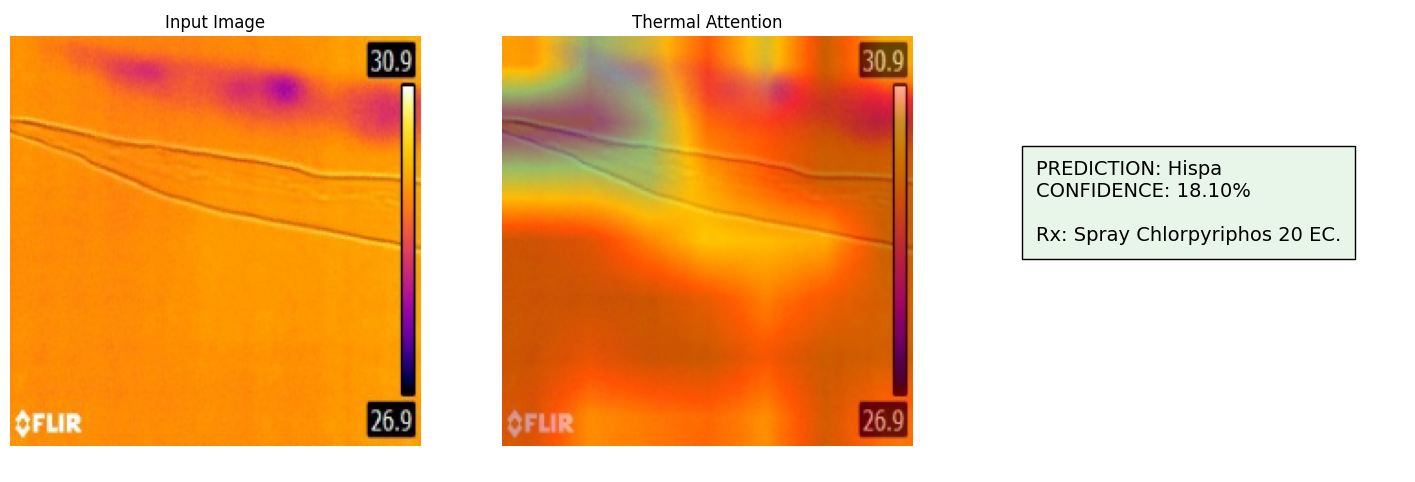

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# ==========================================
# 1. SETUP MODEL & DATA
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Define Classes manually to avoid dependency on dataset loading
class_names = ['Blast', 'BLB', 'Healthy', 'Hispa', 'Leaf Folder', 'Leaf Spot']

# Load VGG16
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
for param in model.features.parameters():
    param.requires_grad = False

# Rebuild Classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)
model = model.to(device)
model.eval()
print("✅ Model Loaded")

# ==========================================
# 2. DEFINE GRAD-CAM TOOL (The Fixed Version)
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.target_layer.register_forward_hook(self.save_info)

    def save_info(self, module, input, output):
        self.activations = output
        output.requires_grad_(True) # Force tracking
        output.retain_grad()        # Save gradients

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()
        
        self.gradients = self.activations.grad
        if self.gradients is None:
            raise ValueError("Gradients are missing!")

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy(), output

# Initialize GradCAM on the last layer
target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer)
print("✅ GradCAM Tool Ready")

# ==========================================
# 3. DEFINE VISUALIZATION DASHBOARD
# ==========================================
PRESCRIPTION_DB = {
    'Blast': {'Rx': "Spray Tricyclazole 75 WP (0.6g/L).", 'Pathology': "Fungal infection."},
    'BLB': {'Rx': "Spray Streptocycline + Copper Oxychloride.", 'Pathology': "Bacterial blight."},
    'Healthy': {'Rx': "Maintain NPK fertilizers.", 'Pathology': "No disease."},
    'Hispa': {'Rx': "Spray Chlorpyriphos 20 EC.", 'Pathology': "Beetle damage."},
    'Leaf Folder': {'Rx': "Apply Cartap Hydrochloride.", 'Pathology': "Larval folding."},
    'Leaf Spot': {'Rx': "Spray Mancozeb.", 'Pathology': "Brown spot fungus."}
}

def diagnose_and_visualize(image_path):
    # Load Image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read image file.")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(img, (224, 224))
    
    # Preprocess
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = preprocess(original_img).unsqueeze(0).to(device)
    input_tensor.requires_grad_() # CRITICAL FIX
    
    # Run Grad-CAM
    heatmap, output = grad_cam(input_tensor)
    
    # Get Prediction
    probs = F.softmax(output, dim=1)
    conf, pred_idx = torch.max(probs, 1)
    predicted_class = class_names[pred_idx.item()]
    
    # Overlay
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(original_img); ax[0].set_title("Input Image"); ax[0].axis('off')
    ax[1].imshow(superimposed); ax[1].set_title("Thermal Attention"); ax[1].axis('off')
    
    info = PRESCRIPTION_DB.get(predicted_class, {'Rx': 'Unknown', 'Pathology': 'Unknown'})
    text = f"PREDICTION: {predicted_class}\nCONFIDENCE: {conf.item()*100:.2f}%\n\nRx: {info['Rx']}"
    ax[2].text(0.1, 0.5, text, fontsize=14, bbox=dict(facecolor='#E8F5E9', pad=10))
    ax[2].axis('off')
    plt.show()

# ==========================================
# 4. RUN TEST
# ==========================================
# UPDATE THIS PATH
dataset_root = r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset' 
test_class = 'Blast' # Change to test other folders

try:
    folder = os.path.join(dataset_root, test_class)
    files = os.listdir(folder)
    if files:
        target = os.path.join(folder, random.choice(files))
        print(f"Testing: {target}")
        diagnose_and_visualize(target)
    else:
        print(f"Folder is empty: {folder}")
except Exception as e:
    print(f"Path Error: {e}")

Loading Model on cuda...
✅ Model Loaded Successfully
✅ Found 636 images for evaluation.

Calculating Metrics (this may take a moment)...

       CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Blast       0.35      0.08      0.13       220
         BLB       0.00      0.00      0.00        67
     Healthy       0.00      0.00      0.00        93
       Hispa       0.20      0.51      0.28       142
 Leaf Folder       0.01      0.06      0.02        34
   Leaf Spot       0.29      0.07      0.12        80

    accuracy                           0.16       636
   macro avg       0.14      0.12      0.09       636
weighted avg       0.20      0.16      0.13       636



C:\Users\jeevabharathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jeevabharathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jeevabharathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

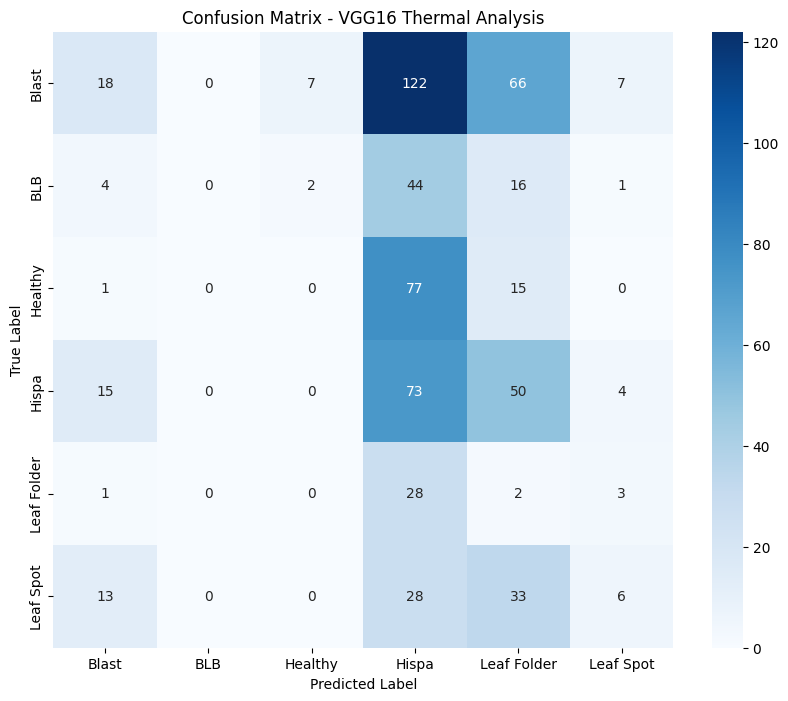


Running Visual Diagnosis on: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset\Blast\Thermalimage1a.jpg


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_15876\1407723730.py:128: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(), 0)


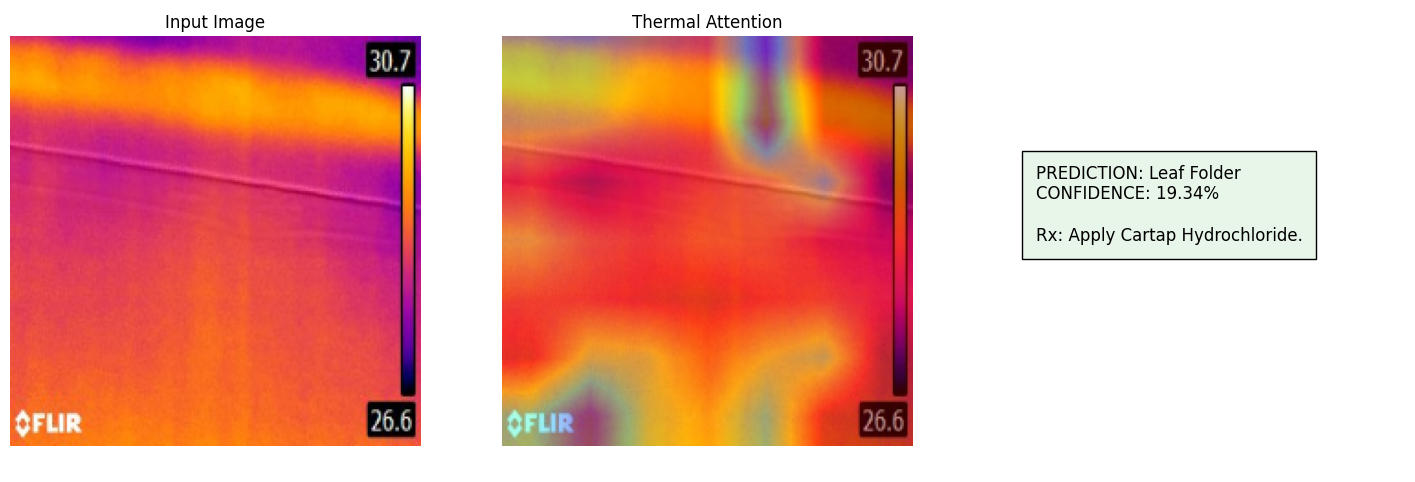

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATASET_ROOT = r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset'  # <--- CHECK THIS PATH
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classes (Must match folder names exactly)
CLASS_NAMES = ['Blast', 'BLB', 'Healthy', 'Hispa', 'Leaf Folder', 'Leaf Spot']

# ==========================================
# 2. MODEL SETUP (VGG16)
# ==========================================
print(f"Loading Model on {DEVICE}...")
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze features
for param in model.features.parameters():
    param.requires_grad = False

# Rebuild Classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(CLASS_NAMES))
)

model = model.to(DEVICE)
model.eval() # Set to evaluation mode for metrics
print("✅ Model Loaded Successfully")

# ==========================================
# 3. METRICS: F1 SCORE & CONFUSION MATRIX
# ==========================================
# Data Transform for Testing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Dataset
try:
    test_dataset = datasets.ImageFolder(DATASET_ROOT, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"✅ Found {len(test_dataset)} images for evaluation.")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    test_loader = None

if test_loader:
    print("\nCalculating Metrics (this may take a moment)...")
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # --- A. CLASSIFICATION REPORT (F1, Precision, Recall) ---
    print("\n" + "="*40)
    print("       CLASSIFICATION REPORT")
    print("="*40)
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    # --- B. CONFUSION MATRIX ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix - VGG16 Thermal Analysis')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# ==========================================
# 4. THERMAL DASHBOARD (Grad-CAM)
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.target_layer.register_forward_hook(self.save_info)

    def save_info(self, module, input, output):
        self.activations = output
        output.requires_grad_(True) # Force tracking
        output.retain_grad()        # Save gradients

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()
        
        self.gradients = self.activations.grad
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy(), output

# Initialize GradCAM
target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer)

PRESCRIPTION_DB = {
    'Blast': {'Rx': "Spray Tricyclazole 75 WP (0.6g/L).", 'Pathology': "Fungal infection."},
    'BLB': {'Rx': "Spray Streptocycline + Copper Oxychloride.", 'Pathology': "Bacterial blight."},
    'Healthy': {'Rx': "Maintain NPK fertilizers.", 'Pathology': "No disease."},
    'Hispa': {'Rx': "Spray Chlorpyriphos 20 EC.", 'Pathology': "Beetle damage."},
    'Leaf Folder': {'Rx': "Apply Cartap Hydrochloride.", 'Pathology': "Larval folding."},
    'Leaf Spot': {'Rx': "Spray Mancozeb.", 'Pathology': "Brown spot fungus."}
}

def diagnose_and_visualize(image_path):
    img = cv2.imread(image_path)
    if img is None: return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(img, (224, 224))
    
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = preprocess(original_img).unsqueeze(0).to(DEVICE)
    input_tensor.requires_grad_() # Enable Gradients
    
    heatmap, output = grad_cam(input_tensor)
    
    probs = F.softmax(output, dim=1)
    conf, pred_idx = torch.max(probs, 1)
    predicted_class = CLASS_NAMES[pred_idx.item()]
    
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(original_img); ax[0].set_title("Input Image"); ax[0].axis('off')
    ax[1].imshow(superimposed); ax[1].set_title("Thermal Attention"); ax[1].axis('off')
    
    info = PRESCRIPTION_DB.get(predicted_class, {'Rx': 'Unknown', 'Pathology': 'Unknown'})
    text = f"PREDICTION: {predicted_class}\nCONFIDENCE: {conf.item()*100:.2f}%\n\nRx: {info['Rx']}"
    ax[2].text(0.1, 0.5, text, fontsize=12, bbox=dict(facecolor='#E8F5E9', pad=10))
    ax[2].axis('off')
    plt.show()

# Run Single Test
try:
    test_class = 'Blast' # Change to test other folders
    folder = os.path.join(DATASET_ROOT, test_class)
    if os.path.exists(folder):
        files = os.listdir(folder)
        if files:
            target = os.path.join(folder, random.choice(files))
            print(f"\nRunning Visual Diagnosis on: {target}")
            diagnose_and_visualize(target)
except Exception as e:
    print(f"Visualization Error: {e}")